# Types of Audio Features for Machine Learning

**Video ID:** ZZ9u1vUtcIA  
**Title:** Types of Audio Features for Machine Learning

This notebook provides a comprehensive guide to understanding and extracting different types of audio features used in machine learning. It acts as a theoretical map categorizing the vast landscape of audio features before diving into code implementation.

## Key Question: What kinds of data can we actually get from sound?

---

## 1. The Three Dimensions of Classification

When choosing a feature for your ML model, you must define it within these three dimensions:

### A. Level of Abstraction
How much "musical" or "human" meaning does the feature carry?

#### **High-Level Features (Semantic)**
- Carry human-understandable meaning
- Examples: Music Genre, Mood (Sad/Happy), Key (C Major), Instrumentation (Guitar vs. Piano)
- **Note:** Usually cannot be extracted directly from waveform; often the output of your ML model

#### **Mid-Level Features**
- Musical characteristics that are technically defined but perceptually relevant
- Examples: Pitch (Hz), Beat locations, Rhythm patterns, MFCCs (Timbre)

#### **Low-Level Features**
- Purely mathematical statistics of the signal with little human interpretability
- Examples: Zero-Crossing Rate, Spectral Centroid, Amplitude Envelope

---

### B. Temporal Scope
How much time does the feature represent?

#### **Instantaneous (Frame-Level)**
- Calculated for a tiny window of time (e.g., 20-50ms)
- Usage: Track how sound evolves over time (e.g., spectrogram)

#### **Segment-Level (Texture)**
- Calculated over a few seconds (e.g., a "texture window")
- Aggregates instantaneous features (Mean/Variance) to capture the "vibe" of a short section

#### **Global-Level**
- One single vector representing an entire song or recording
- Usage: Recommender systems (Spotify) often use global stats (e.g., "This song is generally fast and loud")

---

### C. The Signal Domain
Which mathematical view of the signal is used?

#### **Time Domain**
- Extracted directly from raw waveform samples (Amplitude vs. Time)
- Computation: Very fast (no Fourier Transform needed)
- Examples: Amplitude Envelope, RMS Energy, Zero-Crossing Rate (ZCR)

#### **Frequency Domain**
- Extracted from the Spectrum (Magnitude vs. Frequency) using DFT/FFT
- Captures the "fingerprint" of sound, but loses time information
- Examples: Band Energy Ratio, Spectral Centroid, Spectral Flux

#### **Time-Frequency Domain**
- Combines both; shows how frequency content changes over time
- Examples: Spectrogram, Mel-Spectrogram, MFCCs, Chroma
    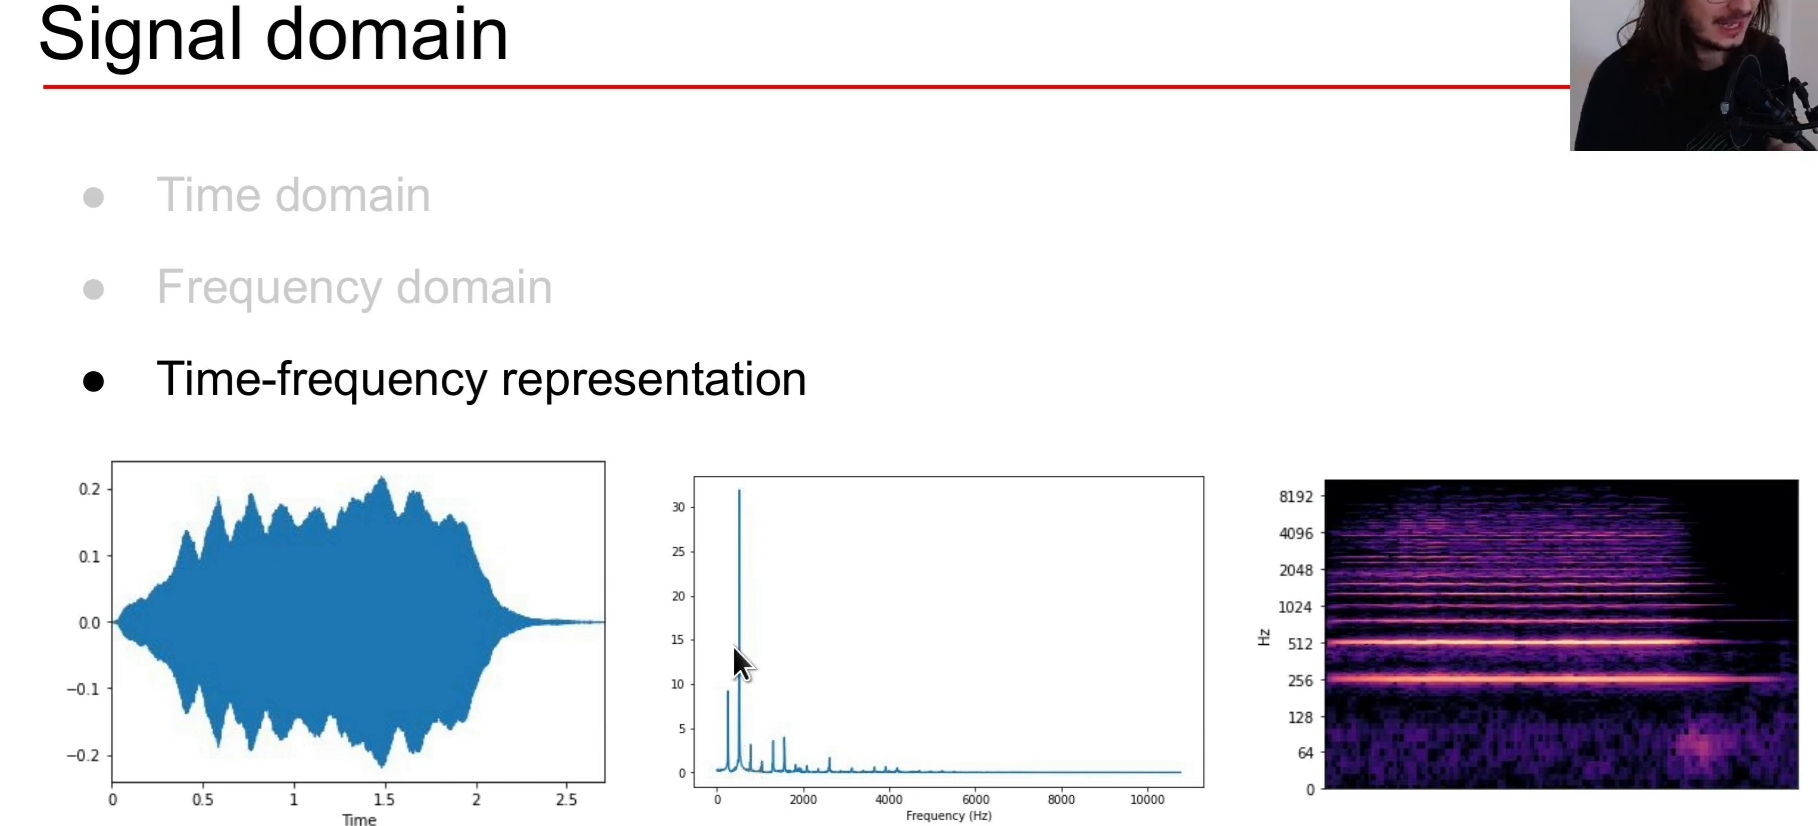
---

## 2. Setup and Imports

In [1]:
# Install required libraries (uncomment if needed)
# !pip install librosa numpy matplotlib scipy

import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy import signal
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (14, 6)

## 3. Generate Sample Audio Signal

Let's create a synthetic audio signal for demonstration purposes.

In [2]:
# Generate a sample audio signal
sr = 22050  # Sample rate
duration = 3  # seconds
t = np.linspace(0, duration, int(sr * duration))

# Create a complex signal with multiple frequencies
# Simulating a musical note with harmonics
fundamental = 440  # A4 note
audio_signal = (
    0.5 * np.sin(2 * np.pi * fundamental * t) +  # Fundamental
    0.3 * np.sin(2 * np.pi * fundamental * 2 * t) +  # 2nd harmonic
    0.2 * np.sin(2 * np.pi * fundamental * 3 * t) +  # 3rd harmonic
    0.1 * np.sin(2 * np.pi * fundamental * 4 * t)    # 4th harmonic
)

# Add amplitude envelope (attack-decay-sustain-release)
envelope = np.concatenate([
    np.linspace(0, 1, int(sr * 0.1)),  # Attack
    np.linspace(1, 0.7, int(sr * 0.2)),  # Decay
    np.ones(int(sr * 2.4)) * 0.7,  # Sustain
    np.linspace(0.7, 0, int(sr * 0.3))  # Release
])

audio_signal = audio_signal * envelope

# Add some noise for realism
audio_signal += 0.02 * np.random.randn(len(audio_signal))

print(f"Sample Rate: {sr} Hz")
print(f"Duration: {duration} seconds")
print(f"Total Samples: {len(audio_signal)}")

Sample Rate: 22050 Hz
Duration: 3 seconds
Total Samples: 66150


## 4. Time Domain Features

### 4.1 Amplitude Envelope (AE)

The amplitude envelope represents the maximum amplitude per frame. It's useful for **onset detection** (finding the start of a note).

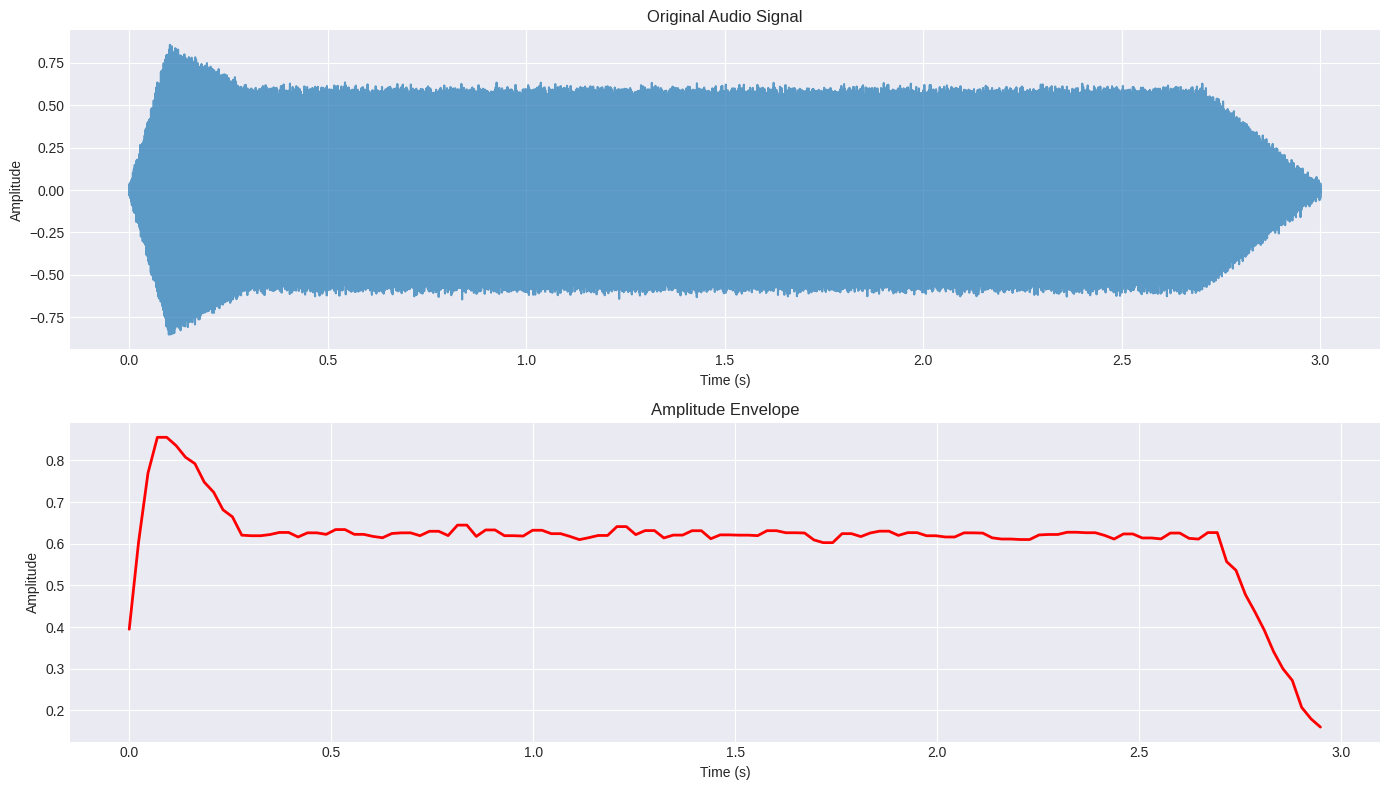

Amplitude Envelope Shape: (128,)
Max Amplitude: 0.8554
Mean Amplitude: 0.6091


In [3]:
def amplitude_envelope(signal, frame_size, hop_length):
    """
    Calculate the amplitude envelope of a signal.
    
    Parameters:
    - signal: Input audio signal
    - frame_size: Size of each frame in samples
    - hop_length: Number of samples between successive frames
    
    Returns:
    - Amplitude envelope array
    """
    amplitude_env = []
    
    for i in range(0, len(signal) - frame_size, hop_length):
        frame = signal[i:i + frame_size]
        amplitude_env.append(np.max(np.abs(frame)))
    
    return np.array(amplitude_env)

# Calculate amplitude envelope
frame_size = 1024
hop_length = 512
ae = amplitude_envelope(audio_signal, frame_size, hop_length)

# Plot
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(t, audio_signal, alpha=0.7)
plt.title('Original Audio Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
frames = np.arange(len(ae))
time_frames = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)
plt.plot(time_frames, ae, color='red', linewidth=2)
plt.title('Amplitude Envelope')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Amplitude Envelope Shape: {ae.shape}")
print(f"Max Amplitude: {np.max(ae):.4f}")
print(f"Mean Amplitude: {np.mean(ae):.4f}")

### 4.2 Root-Mean-Square (RMS) Energy

RMS Energy represents the average power of the signal. It's useful for **segmentation** (Voice vs. Silence).

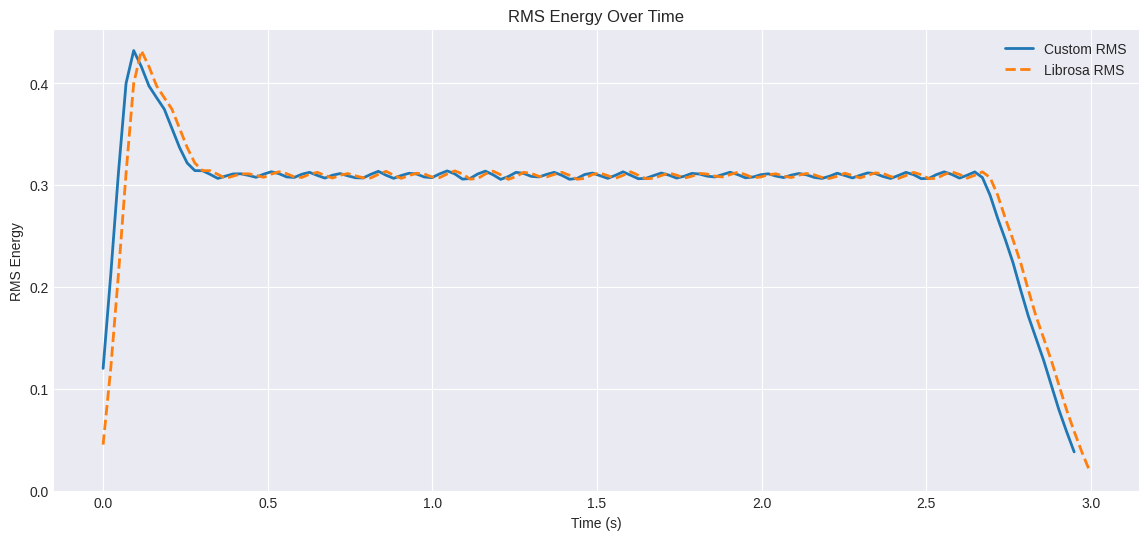

RMS Energy Shape: (128,)
Max RMS: 0.4320
Mean RMS: 0.2987


In [20]:
def rms_energy(signal, frame_size, hop_length):
    """
    Calculate the RMS energy of a signal.
    Parameters:
    - signal: Input audio signal
    - frame_size: Size of each frame in samples
    - hop_length: Number of samples between successive frames
    Returns:
    - RMS energy array
    """
    rms = []
    for i in range(0, len(signal) - frame_size, hop_length):
        frame = signal[i:i + frame_size]
        rms_value = np.sqrt(np.mean(frame**2))
        rms.append(rms_value)
    return np.array(rms)

# Calculate RMS energy
rms = rms_energy(audio_signal, frame_size, hop_length)

# Using librosa for comparison
rms_librosa = librosa.feature.rms(y=audio_signal, frame_length=frame_size, hop_length=hop_length)[0]

# Create time frames that match the RMS array length
time_frames = librosa.frames_to_time(np.arange(len(rms_librosa)), sr=sr, hop_length=hop_length)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_frames[:len(rms)], rms, label='Custom RMS', linewidth=2)
plt.plot(time_frames, rms_librosa, label='Librosa RMS', linestyle='--', linewidth=2)
plt.title('RMS Energy Over Time')
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy')
plt.legend()
plt.grid(True)
plt.show()

print(f"RMS Energy Shape: {rms.shape}")
print(f"Max RMS: {np.max(rms):.4f}")
print(f"Mean RMS: {np.mean(rms):.4f}")

### 4.3 Zero-Crossing Rate (ZCR)

ZCR measures how often the signal crosses zero. It's a **noisiness index** useful for distinguishing percussive vs. pitched sounds.

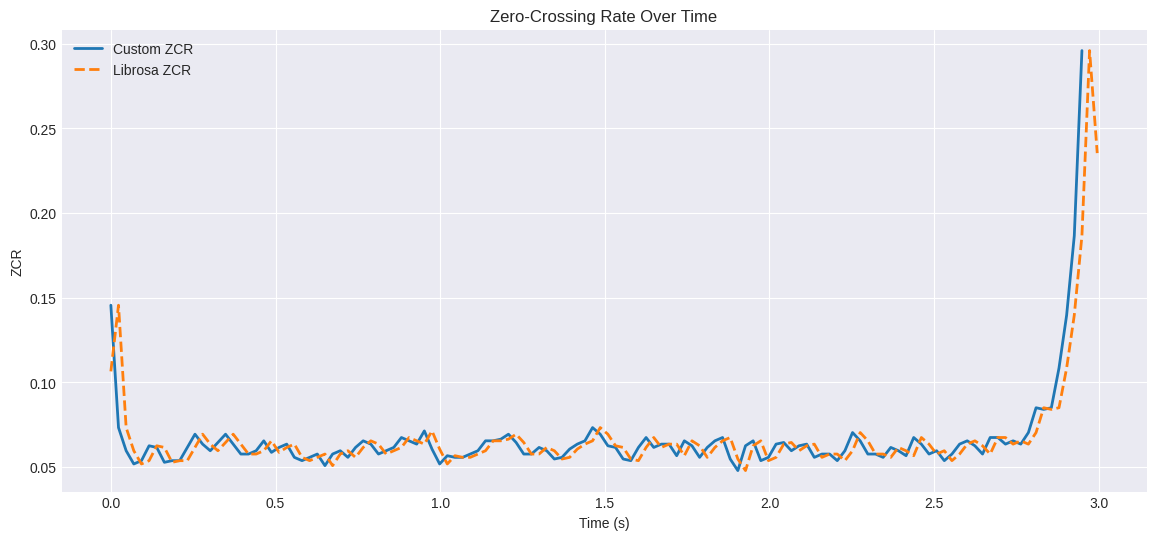

ZCR Shape: (128,)
Max ZCR: 0.2959
Mean ZCR: 0.0659


In [19]:
def zero_crossing_rate(signal, frame_size, hop_length):
    """
    Calculate the zero-crossing rate of a signal.
    Parameters:
    - signal: Input audio signal
    - frame_size: Size of each frame in samples
    - hop_length: Number of samples between successive frames
    Returns:
    - ZCR array
    """
    zcr = []
    for i in range(0, len(signal) - frame_size, hop_length):
        frame = signal[i:i + frame_size]
        # Count sign changes
        zero_crossings = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
        zcr.append(zero_crossings / frame_size)
    return np.array(zcr)

# Calculate ZCR
zcr = zero_crossing_rate(audio_signal, frame_size, hop_length)

# Using librosa for comparison
zcr_librosa = librosa.feature.zero_crossing_rate(audio_signal, frame_length=frame_size, hop_length=hop_length)[0]

# Create time frames that match the ZCR array length
time_frames = librosa.frames_to_time(np.arange(len(zcr_librosa)), sr=sr, hop_length=hop_length)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_frames[:len(zcr)], zcr, label='Custom ZCR', linewidth=2)
plt.plot(time_frames, zcr_librosa, label='Librosa ZCR', linestyle='--', linewidth=2)
plt.title('Zero-Crossing Rate Over Time')
plt.xlabel('Time (s)')
plt.ylabel('ZCR')
plt.legend()
plt.grid(True)
plt.show()

print(f"ZCR Shape: {zcr.shape}")
print(f"Max ZCR: {np.max(zcr):.4f}")
print(f"Mean ZCR: {np.mean(zcr):.4f}")

## 5. Frequency Domain Features

### 5.1 Spectral Centroid

The spectral centroid is the "center of mass" of the spectrum. It indicates the **brightness** of a sound (Trumpet vs. Cello).

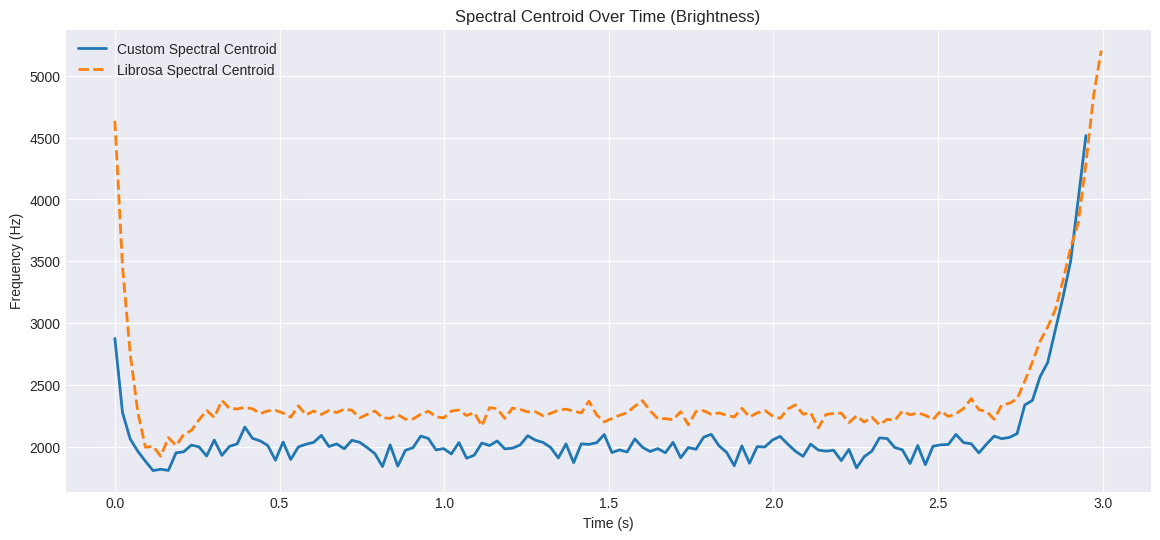

Spectral Centroid Shape: (128,)
Max Centroid: 4517.53 Hz
Mean Centroid: 2077.24 Hz


In [18]:
def spectral_centroid(signal, sr, frame_size, hop_length):
    """
    Calculate the spectral centroid of a signal.
    Parameters:
    - signal: Input audio signal
    - sr: Sample rate
    - frame_size: Size of each frame in samples
    - hop_length: Number of samples between successive frames
    Returns:
    - Spectral centroid array
    """
    centroids = []
    for i in range(0, len(signal) - frame_size, hop_length):
        frame = signal[i:i + frame_size]
        # Apply FFT
        spectrum = np.abs(np.fft.rfft(frame))
        freqs = np.fft.rfftfreq(frame_size, 1/sr)
        # Calculate centroid
        centroid = np.sum(freqs * spectrum) / np.sum(spectrum)
        centroids.append(centroid)
    return np.array(centroids)

# Calculate spectral centroid
sc = spectral_centroid(audio_signal, sr, frame_size, hop_length)

# Using librosa for comparison
sc_librosa = librosa.feature.spectral_centroid(y=audio_signal, sr=sr, n_fft=frame_size, hop_length=hop_length)[0]

# Create time frames that match the spectral centroid array length
time_frames = librosa.frames_to_time(np.arange(len(sc_librosa)), sr=sr, hop_length=hop_length)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_frames[:len(sc)], sc, label='Custom Spectral Centroid', linewidth=2)
plt.plot(time_frames, sc_librosa, label='Librosa Spectral Centroid', linestyle='--', linewidth=2)
plt.title('Spectral Centroid Over Time (Brightness)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Spectral Centroid Shape: {sc.shape}")
print(f"Max Centroid: {np.max(sc):.2f} Hz")
print(f"Mean Centroid: {np.mean(sc):.2f} Hz")

### 5.2 Spectral Bandwidth

Spectral bandwidth measures the **spectral spread** around the centroid. Useful for **timbre analysis**.

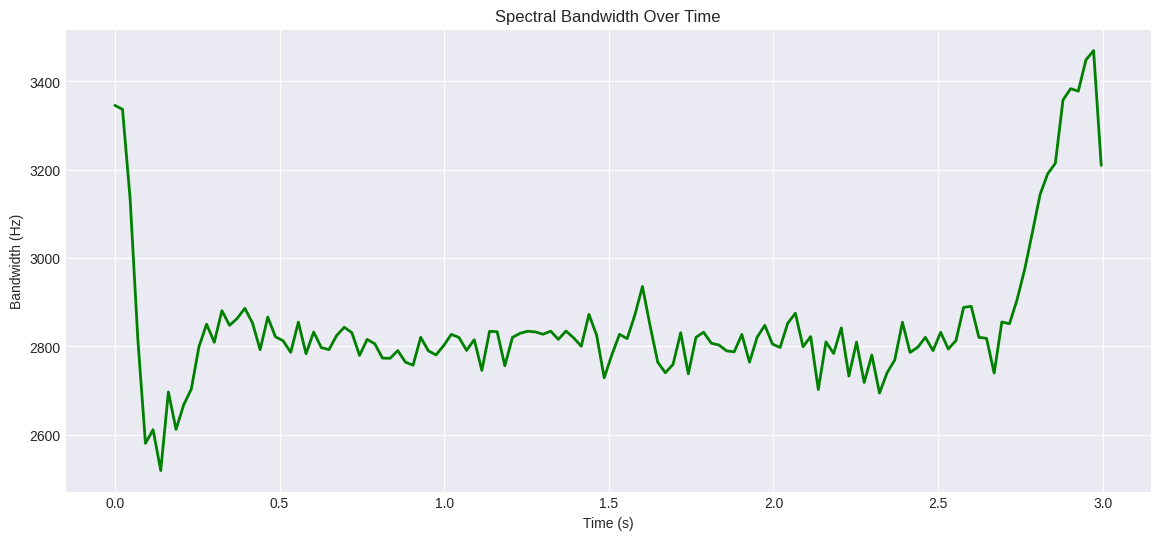

Spectral Bandwidth Shape: (130,)
Max Bandwidth: 3469.95 Hz
Mean Bandwidth: 2849.77 Hz


In [17]:
# Calculate spectral bandwidth using librosa
bandwidth = librosa.feature.spectral_bandwidth(y=audio_signal, sr=sr, n_fft=frame_size, hop_length=hop_length)[0]

# Create time frames that match the bandwidth array length
time_frames = librosa.frames_to_time(np.arange(len(bandwidth)), sr=sr, hop_length=hop_length)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_frames, bandwidth, color='green', linewidth=2)
plt.title('Spectral Bandwidth Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Bandwidth (Hz)')
plt.grid(True)
plt.show()

print(f"Spectral Bandwidth Shape: {bandwidth.shape}")
print(f"Max Bandwidth: {np.max(bandwidth):.2f} Hz")
print(f"Mean Bandwidth: {np.mean(bandwidth):.2f} Hz")

### 5.3 Band Energy Ratio

Compares energy in different frequency bands (e.g., bass vs. treble).

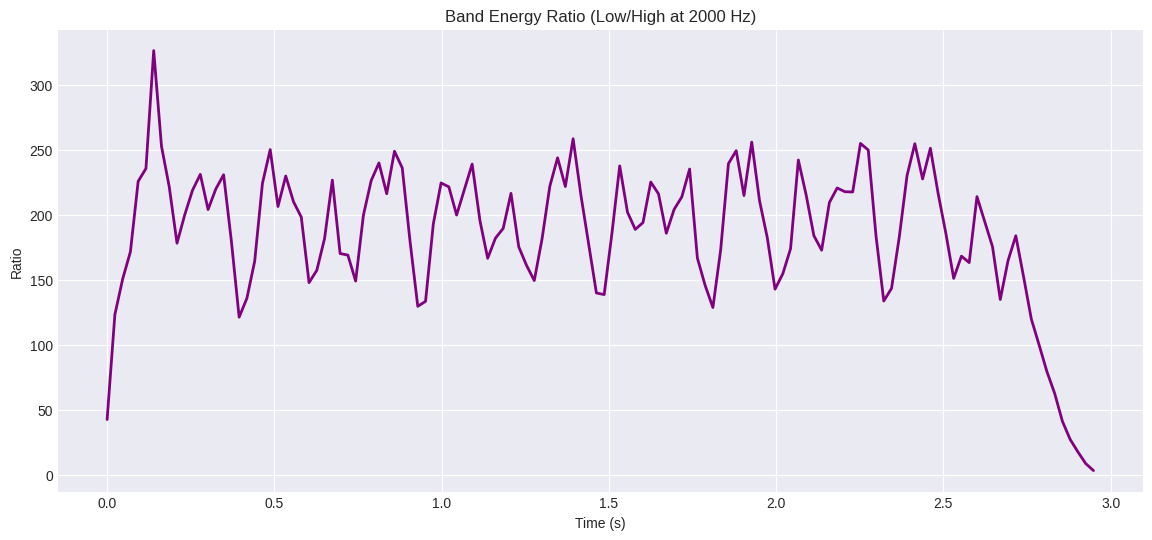

Band Energy Ratio Shape: (128,)
Max BER: 326.1318
Mean BER: 185.7065


In [8]:
def band_energy_ratio(signal, sr, frame_size, hop_length, split_freq=2000):
    """
    Calculate the ratio of energy below and above a split frequency.
    
    Parameters:
    - signal: Input audio signal
    - sr: Sample rate
    - frame_size: Size of each frame in samples
    - hop_length: Number of samples between successive frames
    - split_freq: Frequency to split low and high bands (Hz)
    
    Returns:
    - Band energy ratio array
    """
    ber = []
    
    for i in range(0, len(signal) - frame_size, hop_length):
        frame = signal[i:i + frame_size]
        
        # Apply FFT
        spectrum = np.abs(np.fft.rfft(frame))**2
        freqs = np.fft.rfftfreq(frame_size, 1/sr)
        
        # Split into low and high bands
        split_idx = np.argmin(np.abs(freqs - split_freq))
        low_energy = np.sum(spectrum[:split_idx])
        high_energy = np.sum(spectrum[split_idx:])
        
        # Calculate ratio
        ratio = low_energy / (high_energy + 1e-10)  # Avoid division by zero
        ber.append(ratio)
    
    return np.array(ber)

# Calculate band energy ratio
ber = band_energy_ratio(audio_signal, sr, frame_size, hop_length, split_freq=2000)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_frames, ber, color='purple', linewidth=2)
plt.title('Band Energy Ratio (Low/High at 2000 Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Ratio')
plt.grid(True)
plt.show()

print(f"Band Energy Ratio Shape: {ber.shape}")
print(f"Max BER: {np.max(ber):.4f}")
print(f"Mean BER: {np.mean(ber):.4f}")

### 5.4 Spectral Flux

Measures how quickly the spectrum is changing. Useful for detecting **onsets** and **transients**.

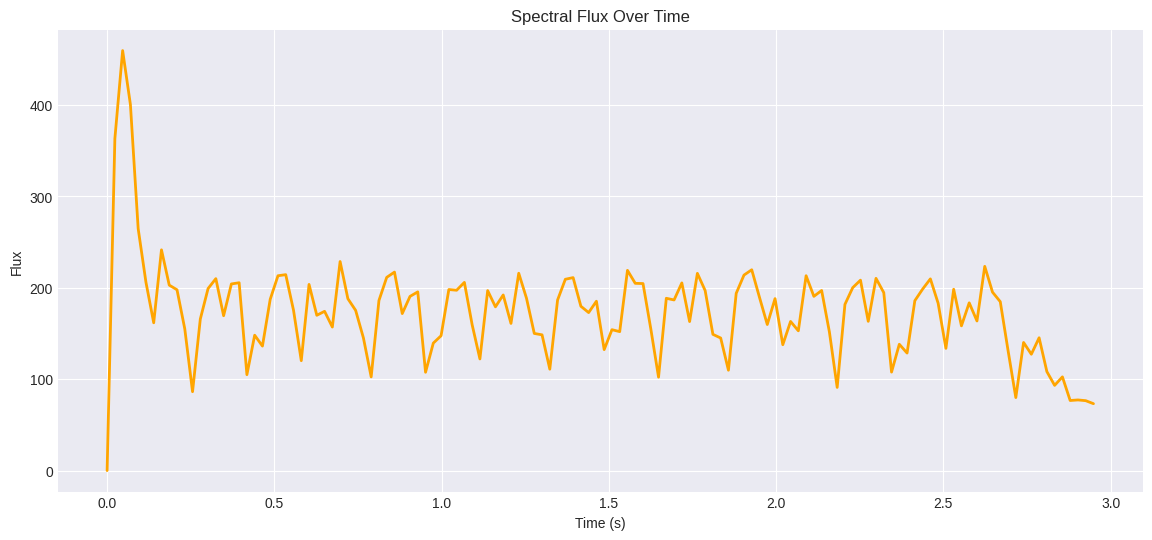

Spectral Flux Shape: (128,)
Max Flux: 459.68
Mean Flux: 173.55


In [9]:
def spectral_flux(signal, sr, frame_size, hop_length):
    """
    Calculate the spectral flux of a signal.
    
    Parameters:
    - signal: Input audio signal
    - sr: Sample rate
    - frame_size: Size of each frame in samples
    - hop_length: Number of samples between successive frames
    
    Returns:
    - Spectral flux array
    """
    flux = []
    prev_spectrum = None
    
    for i in range(0, len(signal) - frame_size, hop_length):
        frame = signal[i:i + frame_size]
        
        # Apply FFT
        spectrum = np.abs(np.fft.rfft(frame))
        
        if prev_spectrum is not None:
            # Calculate difference between consecutive spectra
            diff = spectrum - prev_spectrum
            # Sum only positive differences (increase in energy)
            flux_value = np.sum(diff[diff > 0])
            flux.append(flux_value)
        else:
            flux.append(0)
        
        prev_spectrum = spectrum
    
    return np.array(flux)

# Calculate spectral flux
sf = spectral_flux(audio_signal, sr, frame_size, hop_length)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(time_frames, sf, color='orange', linewidth=2)
plt.title('Spectral Flux Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Flux')
plt.grid(True)
plt.show()

print(f"Spectral Flux Shape: {sf.shape}")
print(f"Max Flux: {np.max(sf):.2f}")
print(f"Mean Flux: {np.mean(sf):.2f}")

## 6. Time-Frequency Domain Features

### 6.1 Spectrogram

The standard image representation showing how frequency content changes over time.

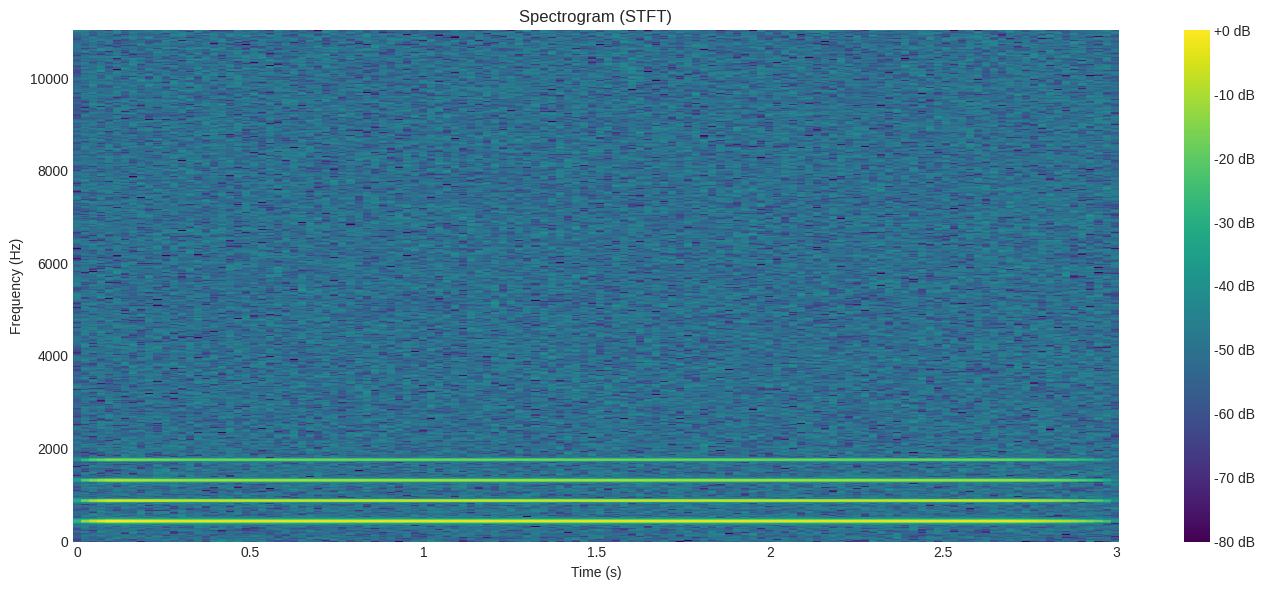

Spectrogram Shape: (513, 130)
Frequency bins: 513
Time frames: 130


In [10]:
# Compute Short-Time Fourier Transform (STFT)
D = librosa.stft(audio_signal, n_fft=frame_size, hop_length=hop_length)
magnitude = np.abs(D)
magnitude_db = librosa.amplitude_to_db(magnitude, ref=np.max)

# Plot spectrogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(magnitude_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (STFT)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

print(f"Spectrogram Shape: {magnitude.shape}")
print(f"Frequency bins: {magnitude.shape[0]}")
print(f"Time frames: {magnitude.shape[1]}")

### 6.2 Mel-Spectrogram

A perceptually weighted spectrogram using the Mel scale, which better matches human hearing.

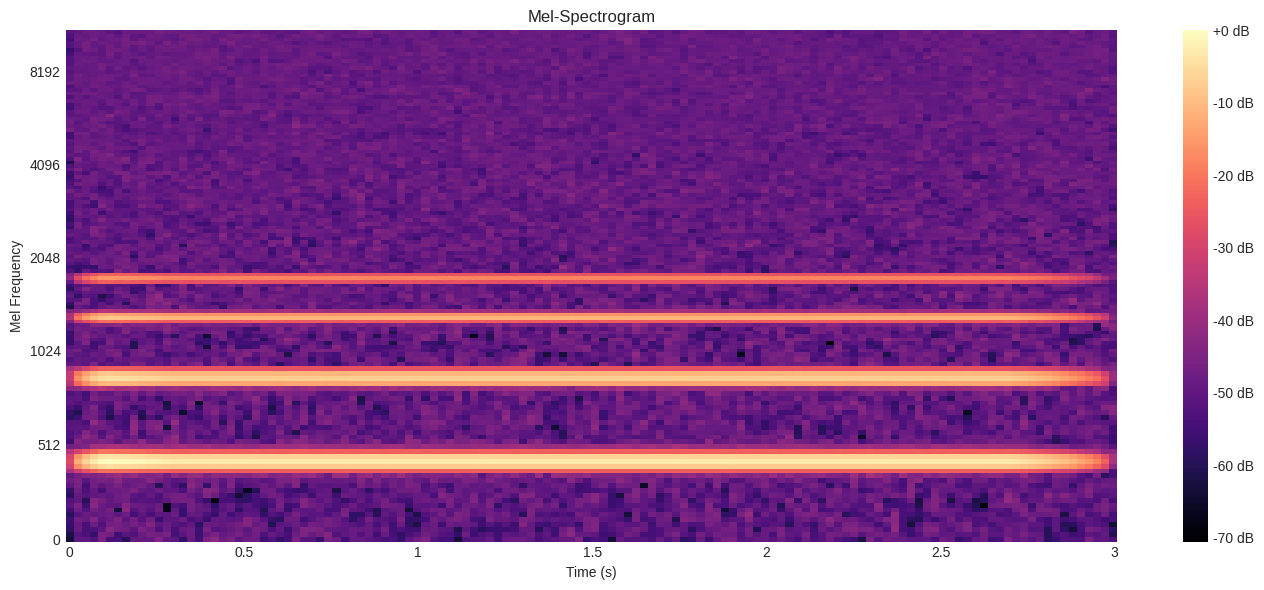

Mel-Spectrogram Shape: (128, 130)
Mel bins: 128
Time frames: 130


In [11]:
# Compute Mel-Spectrogram
mel_spec = librosa.feature.melspectrogram(y=audio_signal, sr=sr, n_fft=frame_size, hop_length=hop_length, n_mels=128)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot Mel-Spectrogram
plt.figure(figsize=(14, 6))
librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()

print(f"Mel-Spectrogram Shape: {mel_spec.shape}")
print(f"Mel bins: {mel_spec.shape[0]}")
print(f"Time frames: {mel_spec.shape[1]}")

### 6.3 MFCCs (Mel-Frequency Cepstral Coefficients)

Decorrelated spectral envelope features. **Standard for Speech Recognition and Speaker Identification**.

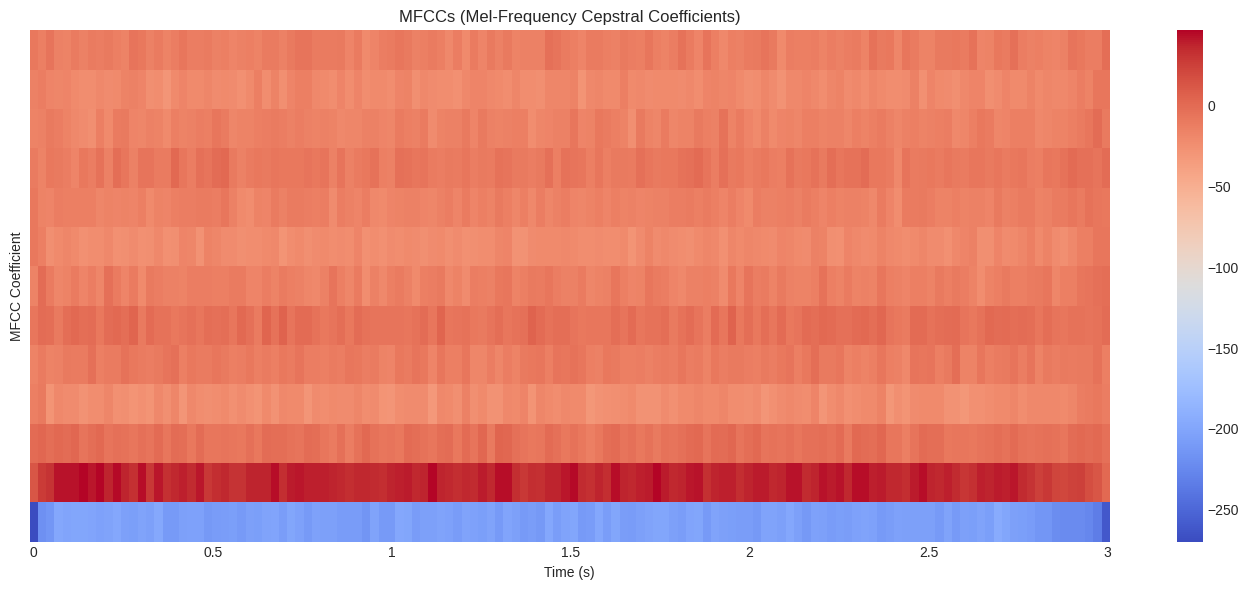

MFCCs Shape: (13, 130)
Number of coefficients: 13
Time frames: 130

MFCC Statistics:
MFCC 0: Mean=-206.91, Std=9.21
MFCC 1: Mean=35.93, Std=6.68
MFCC 2: Mean=-4.11, Std=3.68
MFCC 3: Mean=-22.59, Std=4.27
MFCC 4: Mean=-10.92, Std=3.52
MFCC 5: Mean=-3.89, Std=3.66
MFCC 6: Mean=-13.41, Std=4.18
MFCC 7: Mean=-21.14, Std=3.84
MFCC 8: Mean=-14.44, Std=3.30
MFCC 9: Mean=-8.53, Std=3.77
MFCC 10: Mean=-14.88, Std=3.72
MFCC 11: Mean=-19.99, Std=3.64
MFCC 12: Mean=-12.21, Std=3.70


In [12]:
# Compute MFCCs
mfccs = librosa.feature.mfcc(y=audio_signal, sr=sr, n_mfcc=13, n_fft=frame_size, hop_length=hop_length)

# Plot MFCCs
plt.figure(figsize=(14, 6))
librosa.display.specshow(mfccs, sr=sr, hop_length=hop_length, x_axis='time', cmap='coolwarm')
plt.colorbar()
plt.title('MFCCs (Mel-Frequency Cepstral Coefficients)')
plt.xlabel('Time (s)')
plt.ylabel('MFCC Coefficient')
plt.tight_layout()
plt.show()

print(f"MFCCs Shape: {mfccs.shape}")
print(f"Number of coefficients: {mfccs.shape[0]}")
print(f"Time frames: {mfccs.shape[1]}")

# Show statistics for each MFCC
print("\nMFCC Statistics:")
for i in range(mfccs.shape[0]):
    print(f"MFCC {i}: Mean={np.mean(mfccs[i]):.2f}, Std={np.std(mfccs[i]):.2f}")

### 6.4 Chroma Features

Maps all energy into 12 pitch classes (C, C#, D, ..., B) regardless of octave. **Standard for Chord Recognition and Cover Song Identification**.

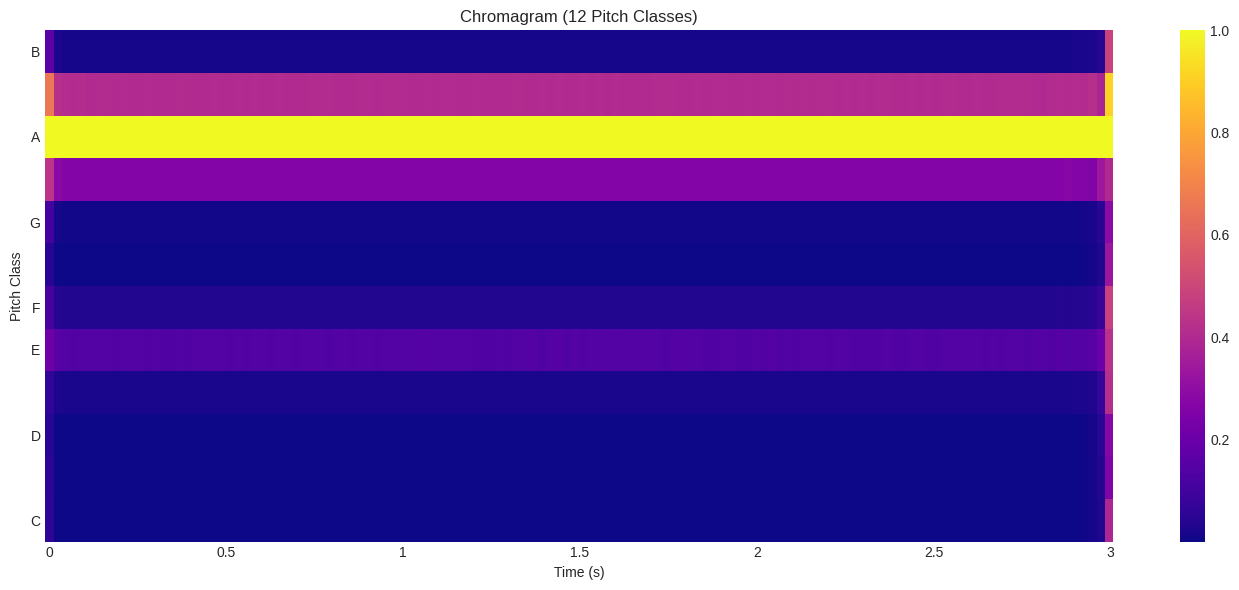

Chroma Shape: (12, 130)
Pitch classes: 12
Time frames: 130

Most common pitch class: A


In [13]:
# Compute Chroma features
chroma = librosa.feature.chroma_stft(y=audio_signal, sr=sr, n_fft=frame_size, hop_length=hop_length)

# Plot Chroma
plt.figure(figsize=(14, 6))
librosa.display.specshow(chroma, sr=sr, hop_length=hop_length, x_axis='time', y_axis='chroma', cmap='plasma')
plt.colorbar()
plt.title('Chromagram (12 Pitch Classes)')
plt.xlabel('Time (s)')
plt.ylabel('Pitch Class')
plt.tight_layout()
plt.show()

print(f"Chroma Shape: {chroma.shape}")
print(f"Pitch classes: {chroma.shape[0]}")
print(f"Time frames: {chroma.shape[1]}")

# Show dominant pitch class over time
dominant_pitch = np.argmax(chroma, axis=0)
pitch_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
print(f"\nMost common pitch class: {pitch_names[np.bincount(dominant_pitch).argmax()]}")

## 7. Feature Aggregation: From Frame-Level to Global

Demonstrating how to aggregate instantaneous features into segment-level and global-level features.

In [15]:
# Example: Aggregating MFCCs

# Frame-level (already computed)
print("Frame-level MFCCs shape:", mfccs.shape)

# Segment-level: Compute statistics over 1-second windows
segment_duration = 1.0  # seconds
frames_per_segment = int(segment_duration * sr / hop_length)

num_segments = mfccs.shape[1] // frames_per_segment
segment_features = []

for i in range(num_segments):
    start_frame = i * frames_per_segment
    end_frame = start_frame + frames_per_segment
    segment = mfccs[:, start_frame:end_frame]
    
    # Compute mean and variance for this segment
    segment_mean = np.mean(segment, axis=1)
    segment_var = np.var(segment, axis=1)
    
    # Concatenate mean and variance
    segment_feature = np.concatenate([segment_mean, segment_var])
    segment_features.append(segment_feature)

segment_features = np.array(segment_features)
print(f"\nSegment-level features shape: {segment_features.shape}")
print(f"(Each segment has {segment_features.shape[1]} features: 13 means + 13 variances)")

# Global-level: Single vector for entire audio
global_mean = np.mean(mfccs, axis=1)
global_var = np.var(mfccs, axis=1)
global_features = np.concatenate([global_mean, global_var])

print(f"\nGlobal-level features shape: {global_features.shape}")
print(f"Global features: {global_features}")

Frame-level MFCCs shape: (13, 130)

Segment-level features shape: (3, 26)
(Each segment has 26 features: 13 means + 13 variances)

Global-level features shape: (26,)
Global features: [-206.90924498   35.93089642   -4.1132227   -22.59327891  -10.91802468
   -3.88785929  -13.40523708  -21.1423705   -14.43842618   -8.53079867
  -14.87718356  -19.99258395  -12.21018005   84.8128204    44.60825123
   13.56394238   18.27512234   12.36678689   13.40448681   17.45197772
   14.71841706   10.91394172   14.23001087   13.87240554   13.28398326
   13.68702267]


## 8. Traditional ML vs. Deep Learning
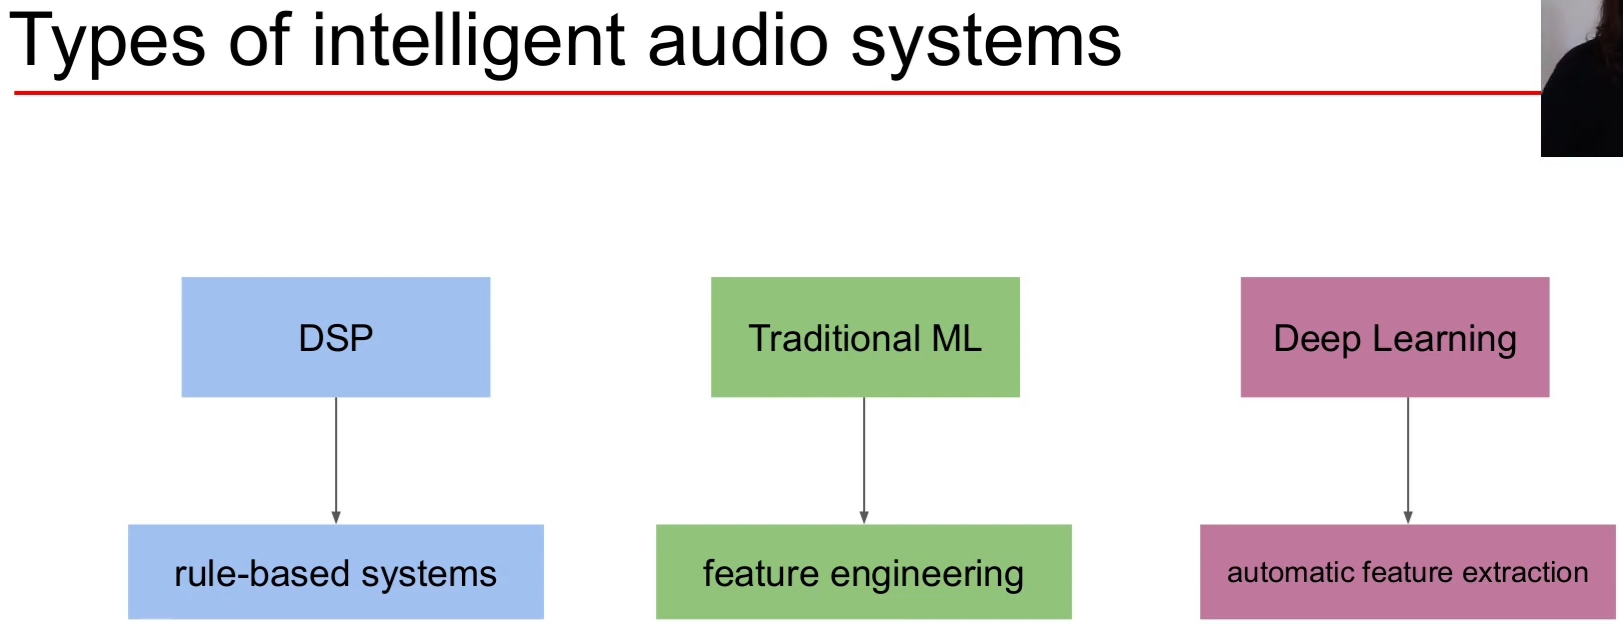
### 8.1 Traditional ML Approach

Manually select and extract specific features, then feed them to classical ML algorithms.

In [ ]:
# Example: Traditional ML Feature Vector
# Manually selecting features for a classification task

traditional_features = {
    'mean_zcr': np.mean(zcr),
    'var_zcr': np.var(zcr),
    'mean_rms': np.mean(rms),
    'var_rms': np.var(rms),
    'mean_spectral_centroid': np.mean(sc),
    'var_spectral_centroid': np.var(sc),
    'mean_bandwidth': np.mean(bandwidth),
    'var_bandwidth': np.var(bandwidth),
}

# Add MFCC statistics
for i in range(mfccs.shape[0]):
    traditional_features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
    traditional_features[f'mfcc_{i}_var'] = np.var(mfccs[i])

# Convert to feature vector
feature_vector = np.array(list(traditional_features.values()))

print("Traditional ML Feature Vector:")
print(f"Total features: {len(feature_vector)}")
print(f"\nFeature names and values:")
for name, value in traditional_features.items():
    print(f"{name:30s}: {value:10.4f}")

print("\n" + "="*60)
print("This feature vector would be fed to algorithms like:")
print("- Support Vector Machine (SVM)")
print("- Random Forest")
print("- Logistic Regression")
print("- K-Nearest Neighbors (KNN)")
print("="*60)

### 8.2 Deep Learning Approach

Feed raw spectrograms or mel-spectrograms directly to neural networks.

In [ ]:
# Example: Deep Learning Input
# The mel-spectrogram is treated as an "image" for CNNs

print("Deep Learning Approach:")
print(f"\nInput: Mel-Spectrogram")
print(f"Shape: {mel_spec.shape}")
print(f"Dimensions: {mel_spec.shape[0]} mel bins × {mel_spec.shape[1]} time frames")
print(f"Total values: {mel_spec.size}")

print("\n" + "="*60)
print("This spectrogram would be fed directly to:")
print("- Convolutional Neural Networks (CNNs)")
print("- Recurrent Neural Networks (RNNs/LSTMs)")
print("- Transformers")
print("\nThe network learns its own features automatically!")
print("It might 'discover' ZCR, Centroid, or entirely new features.")
print("="*60)

# Visualize the difference
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Traditional ML
axes[0].bar(range(len(feature_vector)), feature_vector)
axes[0].set_title('Traditional ML: Hand-Crafted Feature Vector')
axes[0].set_xlabel('Feature Index')
axes[0].set_ylabel('Value')
axes[0].grid(True, alpha=0.3)

# Deep Learning
im = axes[1].imshow(mel_spec_db, aspect='auto', origin='lower', cmap='magma')
axes[1].set_title('Deep Learning: Mel-Spectrogram Input')
axes[1].set_xlabel('Time Frames')
axes[1].set_ylabel('Mel Bins')
plt.colorbar(im, ax=axes[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

## 9. Summary Table of Audio Features

| Feature | Domain | Description | Best Use Case |
|---------|--------|-------------|---------------|
| **AE (Amplitude Envelope)** | Time | Max amplitude per frame | Onset Detection (finding the start of a note) |
| **RMS Energy** | Time | Average power | Segmentation (Voice vs. Silence) |
| **ZCR** | Time | How often signal crosses 0 | Percussive vs. Pitched sounds |
| **Spectral Centroid** | Frequency | Center of spectral mass | Brightness detection (Trumpet vs. Cello) |
| **Bandwidth** | Frequency | Spectral spread | Timbre analysis |
| **MFCCs** | Time-Frequency | Spectral envelope | Speech Recognition, Speaker ID |
| **Chroma** | Time-Frequency | 12 Pitch Classes | Chord Recognition, Cover Song ID |

---

## 10. Practical Example: Feature Extraction Pipeline

A complete pipeline for extracting all features from an audio file.

In [ ]:
def extract_all_features(audio_path, sr=22050, frame_size=2048, hop_length=512):
    """
    Extract all audio features from an audio file.
    
    Parameters:
    - audio_path: Path to audio file
    - sr: Sample rate
    - frame_size: FFT window size
    - hop_length: Number of samples between frames
    
    Returns:
    - Dictionary containing all features
    """
    # Load audio
    y, sr = librosa.load(audio_path, sr=sr)
    
    features = {}
    
    # Time domain features
    features['zcr'] = librosa.feature.zero_crossing_rate(y, frame_length=frame_size, hop_length=hop_length)[0]
    features['rms'] = librosa.feature.rms(y=y, frame_length=frame_size, hop_length=hop_length)[0]
    
    # Frequency domain features
    features['spectral_centroid'] = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=frame_size, hop_length=hop_length)[0]
    features['spectral_bandwidth'] = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=frame_size, hop_length=hop_length)[0]
    features['spectral_rolloff'] = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=frame_size, hop_length=hop_length)[0]
    
    # Time-frequency domain features
    features['mfccs'] = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=frame_size, hop_length=hop_length)
    features['chroma'] = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=frame_size, hop_length=hop_length)
    features['mel_spectrogram'] = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=frame_size, hop_length=hop_length)
    
    # Aggregate to global features
    global_features = {}
    for name, feature in features.items():
        if feature.ndim == 1:
            global_features[f'{name}_mean'] = np.mean(feature)
            global_features[f'{name}_std'] = np.std(feature)
            global_features[f'{name}_max'] = np.max(feature)
            global_features[f'{name}_min'] = np.min(feature)
        else:
            for i in range(feature.shape[0]):
                global_features[f'{name}_{i}_mean'] = np.mean(feature[i])
                global_features[f'{name}_{i}_std'] = np.std(feature[i])
    
    features['global'] = global_features
    
    return features

# Example usage (would work with a real audio file)
print("Feature Extraction Pipeline:")
print("\nUsage:")
print("features = extract_all_features('path/to/audio.wav')")
print("\nReturns a dictionary with:")
print("- Time domain features (ZCR, RMS)")
print("- Frequency domain features (Centroid, Bandwidth, Rolloff)")
print("- Time-frequency features (MFCCs, Chroma, Mel-Spectrogram)")
print("- Global aggregated statistics")
print("\nReady for ML model training!")

## 11. Key Takeaways

### Three Dimensions of Audio Features:
1. **Level of Abstraction**: Low-level (mathematical) → Mid-level (musical) → High-level (semantic)
2. **Temporal Scope**: Instantaneous (frame) → Segment (texture) → Global (entire recording)
3. **Signal Domain**: Time → Frequency → Time-Frequency

### Traditional ML vs. Deep Learning:
- **Traditional ML**: Hand-craft features → Feed to SVM/Random Forest
  - Pros: Less data needed, interpretable
  - Cons: Requires domain expertise

- **Deep Learning**: Feed raw spectrogram → CNN/RNN/Transformer learns features
  - Pros: State-of-the-art accuracy, automatic feature learning
  - Cons: Requires large datasets and GPU power

### Most Important Features:
- **Speech/Voice**: MFCCs
- **Music Genre**: MFCCs + Spectral features + Chroma
- **Chord Recognition**: Chroma
- **Onset Detection**: Amplitude Envelope + Spectral Flux
- **Timbre Analysis**: Spectral Centroid + Bandwidth + MFCCs

---

## References
- Video: "Types of Audio Features for Machine Learning" (ID: ZZ9u1vUtcIA)
- Librosa Documentation: https://librosa.org/
- Digital Signal Processing for Audio

---

**Next Steps:**
1. Try this notebook with real audio files
2. Experiment with different feature combinations
3. Build a simple classifier using extracted features
4. Compare traditional ML vs. deep learning approaches